# 拉勾网产品经理职位数据爬取

## 1. 导入相应模块

In [106]:
import pandas as pd
import math
import time

from urllib import request
import requests

from bs4 import BeautifulSoup as BS
import re

from matplotlib import pyplot as plt
import seaborn as sns
from pylab import mpl
import jieba
import jieba.analyse
from wordcloud import WordCloud

In [105]:
# 下载模块的方式
!pip install seaborn -i http://pypi.douban.com/simple --trusted-host pypi.douban.com

Looking in indexes: http://pypi.douban.com/simple

c:\users\zy\python\python38\lib\threading.py:874: ResourceWarning: unclosed file <_io.BufferedWriter name=11>
  del self._target, self._args, self._kwargs
c:\users\zy\python\python38\lib\threading.py:874: ResourceWarning: unclosed file <_io.BufferedReader name=12>
  del self._target, self._args, self._kwargs
c:\users\zy\python\python38\lib\threading.py:874: ResourceWarning: unclosed file <_io.BufferedReader name=13>
  del self._target, self._args, self._kwargs


## 2. 职位简介爬取

In [7]:
def get_json(url, page_num):
    '''
    从网页获取JSON,使用POST请求,加上头部信息请求的header
    '''
    
    # 搜索栏的网址，调用requests对象的cookies属性获得登录的cookies，并赋值给变量cookies，最后带着cookies去请求
    url1 = 'https://www.lagou.com/jobs/list_%E4%BA%A7%E5%93%81%E7%BB%8F%E7%90%86/p-city_0?px=default&gx= \
            %E5%85%A8%E8%81%8CC&gj=%E5%9C%A8%E6%A0%A1/%E5%BA%94%E5%B1%8A,3%E5%B9%B4%E5%8F%8A%E4%BB%A5%E4%B8%8B&xl= \
            %E6%9C%AC%E7%A7%91,%E7%A1%95%E5%A3%AB#filterBox'
    # 构造请求头信息
    header = {
        'authority': 'www.lagou.com',
        'referer': 'https://www.lagou.com/jobs/list_%E4%BA%A7%E5%93%81%E7%BB%8F%E7%90%86/p-city_0? \
                    px=default&gx=%E5%85%A8%E8%81%8C&gj=%E5%9C%A8%E6%A0%A1/%E5%BA%94%E5%B1%8A,\
                    3%E5%B9%B4%E5%8F%8A%E4%BB%A5%E4%B8%8B&xl=%E6%9C%AC%E7%A7%91,%E7%A1%95%E5%A3%AB',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) \
                       Chrome/66.0.3359.139 Safari/537.36',
    }
    # 构造表单信息
    form_data = {
        'first': 'true',
        'pn': page_num,
        'kd': '产品经理',
    }
    
    session = requests.Session() 
    cookie = session.get(url = url1, headers = header, timeout = 5).cookies
    res = requests.post(url, headers = header, data = form_data, cookies = cookie, timeout = 5)
    res.encoding = 'utf-8'
    page_data = res.json()
    return page_data

In [8]:
# 预览第一页内容
url = 'https://www.lagou.com/jobs/positionAjax.json? \
      gj=%E5%9C%A8%E6%A0%A1%2F%E5%BA%94%E5%B1%8A%2C3%E5%B9%B4%E5%8F%8A%E4%BB%A5%E4%B8%8B \
      &xl=%E6%9C%AC%E7%A7%91%2C%E7%A1%95%E5%A3%AB&px=default&gx=%E5%85%A8%E8%81%8C&needAddtionalResult=false'
first_page = get_json(url,1)
print(first_page)
page_size = first_page['content']['pageSize']
total_count = first_page['content']['positionResult']['totalCount']
print("每页职位数: {}, 总数为: {}".format(page_size, total_count))
position = first_page['content']['positionResult']['result']
df = pd.DataFrame(position)
df.info()

{'success': True, 'msg': None, 'code': 0, 'content': {'showId': '10a8706aa1f84efda6f344ffbb595477', 'hrInfoMap': {'7656855': {'userId': 2745284, 'portrait': 'i/image/M00/5C/AA/Ciqc1F-CrreABtf-AAFhQ7pQxy0891.png', 'realName': '来画', 'positionName': 'HR', 'phone': None, 'receiveEmail': None, 'userLevel': 'G1', 'canTalk': True}, '7809299': {'userId': 17216526, 'portrait': 'i/image/M00/5C/A2/Ciqc1F-CllWAbcazAACHltqNgkc654.png', 'realName': '龙淼', 'positionName': '招聘专员', 'phone': None, 'receiveEmail': None, 'userLevel': 'G1', 'canTalk': True}, '6855628': {'userId': 9641903, 'portrait': 'i/image/M00/5C/A3/Ciqc1F-Cm4mAY1bnAAB1FSDKz5k681.jpg', 'realName': '首席人才官', 'positionName': '', 'phone': None, 'receiveEmail': None, 'userLevel': 'G1', 'canTalk': True}, '7809235': {'userId': 19385238, 'portrait': 'i/image/M00/5C/A5/CgqCHl-Ce_uAUduCAEMysUcgxS4551.png', 'realName': '陈朝俊', 'positionName': '销售', 'phone': None, 'receiveEmail': None, 'userLevel': 'G1', 'canTalk': True}, '6902860': {'userId': 150074

In [9]:
def get_page_num(count):
    '''
    确定要抓取的页数，通过观察，可以发现拉勾网最多显示30页结果
    '''
    page_num = math.ceil(count / 15)
    if page_num > 30:
        return 30
    else:
        return page_num

In [10]:
def get_page_info(jobs_list):
    '''
    获取每一页的职位信息
    '''
    page_info_list = []
    for i in jobs_list:  
        job_info = []
        job_info.append(i['positionId'])
        job_info.append(i['positionName'])        
        job_info.append(i['companyFullName'])
        job_info.append(i['companyShortName'])
        job_info.append(i['companySize'])
        job_info.append(i['industryField'])
        job_info.append(i['financeStage'])
        job_info.append(i['companyLabelList'])
        job_info.append(i['firstType'])
        job_info.append(i['secondType'])
        job_info.append(i['skillLables'])
        job_info.append(i['positionLables'])    
        job_info.append(i['createTime'])    
        job_info.append(i['city'])        
        job_info.append(i['district'])
        job_info.append(i['salary'])        
        job_info.append(i['salaryMonth'])        
        job_info.append(i['workYear'])
        job_info.append(i['education'])        
        job_info.append(i['positionAdvantage'])
        job_info.append(i['resumeProcessRate'])
        page_info_list.append(job_info)
    return page_info_list

In [ ]:
def main():
    url = 'https://www.lagou.com/jobs/positionAjax.json? \
           gj=%E5%9C%A8%E6%A0%A1%2F%E5%BA%94%E5%B1%8A%2C3%E5%B9%B4%E5%8F%8A%E4%BB%A5%E4%B8%8B \
           &xl=%E6%9C%AC%E7%A7%91%2C%E7%A1%95%E5%A3%AB&px=default&gx=%E5%85%A8%E8%81%8C&needAddtionalResult=false'
    first_page = get_json(url,1)
    page_size = first_page['content']['pageSize']
    total_count = first_page['content']['positionResult']['totalCount']
    print("每页职位数: {}, 总数为: {}".format(page_size, total_count))

    num = get_page_num(total_count)
    total_info = []
    for num in range(1, num + 1):
        # 获取每一页的职位相关的信息
        page_data = get_json(url, num)  
        jobs_list = page_data['content']['positionResult']['result']  
        page_info = get_page_info(jobs_list)
        print('第{}页搜索结果：{}'.format(num, page_info))
        total_info += page_info
        print('当前职位总数为：', len(total_info))
        time.sleep(25) # 爬取一次休息一段时间，以免被识别
        
        # 将数据转化为data frame,写入到csv文件中
        df = pd.DataFrame(data=total_info,
                          columns=['职位编号', '职位名称', '公司全称', '公司简称', '公司规模', '所属领域', '融资阶段', '公司标签', 
                                   '职位类型', '第二职位类型', '技能标签', '职位标签', '发布时间',  '城市', '区域', '薪资', '薪酬月数',
                                   '工作经验', '学历要求', '职位福利', '简历处理速度'])
        df.to_csv('pm_position_data.csv', index=False)
        
if __name__ == '__main__':
    main()

## 3. 职位详情描述爬取

In [ ]:
data = pd.read_csv("pm_position_data.csv") #导入上一阶段爬取的数据
data = data.drop_duplicates() # 去重
position_ids = data['职位编号'].tolist()

In [2]:
def get_content(url):
    '''
    获取职位描述信息
    '''
    headers = {
        'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) \
                       Chrome/85.0.4183.121 Mobile Safari/537.36',
    }
    req = request.Request(url, headers=headers)
    page = request.urlopen(req).read()
    content = page.decode('utf-8')
    return content

In [3]:
def get_jd(content):
    '''
    正则化解析页面
    '''
    soup = BS(content, 'lxml')
    job_description = soup.select('div[class="content"]')
    job_description = re.sub(r'</p><p>', '\n', str(job_description[0]))
    result = re.sub(r'<[^>]+>', '', job_description)
    result = result.strip()
    return result

In [6]:
url = 'https://m.lagou.com/jobs/7545658.html'
page = get_content(url)
print(page)
print(get_jd(get_content(url)))

<!DOCTYPE html>
<html>










<head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, minimum-scale=1.0, maximum-scale=1.0, user-scalable=no">
    <meta name="format-detection" content="telephone=no, email=no" />
    <meta name="apple-mobile-web-app-capable" content="yes" />
    <meta name="apple-mobile-web-app-status-bar-style" content="black" />
    <meta name="applicable-device" content="mobile">
    <meta http-equiv="Cache-Control" content="no-transform" />
    <meta http-equiv="Cache-Control" content="no-siteapp" />

        <title>产品经理招聘-2020年话本小说产品经理招聘求职信息-产品经理岗位职责介绍-拉勾招聘</title>
    
        <meta content="产品经理招聘,产品经理岗位职责,话本小说产品经理招聘信息" name="keywords">
    
        <meta content="2020年话本小说产品经理最新招聘求职信息,登录拉勾招聘查看详细的话本小说产品经理的岗位职责要求、工作内容说明、薪资待遇介绍等招聘信息。" name="description">
    
    <link href="//www.lgstatic.com/lg-mobileidt-fed/css/dep/normalize.css-3.0.2/normalize.css?v=201911141135

【超强福利】 
1、公司附近租房，每月1500元租房补贴 
2、入职满一年后，每月提供司龄报销补贴，金额为司龄*1000元 
3、一周工作六天，周末算加班发双薪 
4、免费咖啡零食、全额上六险一金、不打卡、自行团建公司发补贴 

【岗位职责】
1、负责话本小说App的产品规划、需求挖掘、产品设计；
2、根据用户需求优化和管理现有产品、保证产品的快速更新迭代，在用户体验、产品结构逻辑、功能等多方面对产品进行把关；
3、协调各方资源，组织和推动产品的设计和开发上线流程；
4、关注&amp;分析竞品情况；关注&amp;研究行业模式，输出有价值的产品/功能规划；主动搜集&amp;整理&amp;分析用户反馈。

【职位要求】
1、一年以上互联网产品工作经验，具有文娱产品经验者优先；
2、本科及以上学历，具备很强的逻辑思维能力，规划能力；
3、出色的沟通、逻辑思维和资源协调能力，自我驱动导向。


In [ ]:
jd_dict = {}
for i in position_ids:
    url = 'https://m.lagou.com/jobs/' + str(i) + '.html'
    jd = get_jd(get_content(url))
    jd_dict[i] = jd
    time.sleep(15)

In [ ]:
data_jd = pd.DataFrame([jd_dict]).T.reset_index().rename(columns={'index':'职位编号',0:'职位描述'}) 
final_data = pd.merge(data, data_jd, on = '职位编号', how = 'left') # 将两组数据合并
final_data.to_csv('pm_position.csv', index=False, encoding = 'utf-8-sig') # 导出爬取最终数据

## 4. 数据可视化呈现

In [6]:
data = pd.read_csv("pm_position.csv")

In [7]:
data.head()

,职位编号,职位名称,公司全称,公司简称,公司规模,所属领域,融资阶段,公司标签,职位类型,第二职位类型,...,发布时间,城市,区域,薪资,薪酬月数,工作经验,学历要求,职位福利,简历处理速度,职位描述
0,5951556,产品经理,爱客科技（深圳）有限公司,AfterShip,150-500人,电商,不需要融资,"['持续盈利', '国际龙头企业', 'SaaS平台', '极客氛围']",产品|需求|项目类,产品经理,...,2020-10-04 16:50:23,深圳,南山区,15k-25k,14,3-5年,本科,"超牛团队,跨国团队,福利好,产品靓",100,有关 AfterShip\n\n\n2012 年成立于香港，公司自 2014 年起已实现持续...
1,7545658,产品经理,天津量子时代网络科技有限公司,话本小说,15-50人,"移动互联网,文娱丨内容",A轮,"['扁平管理', '创业企业', '弹性工作', '平等文化']",产品|需求|项目类,产品经理,...,2020-10-04 16:06:06,北京,朝阳区,15k-20k,13,1-3年,本科,最大的00后图文对话小说社区,80,【超强福利】 \n1、公司附近租房，每月1500元租房补贴 \n2、入职满一年后，每月提供司...
2,7582034,产品经理,上海唯链信息科技有限公司,VeChain,50-150人,"移动互联网,信息安全",B轮,"['弹性工作', '五险一金', '老司机驾校', '年底N薪']",产品|需求|项目类,产品经理,...,2020-10-04 16:07:26,上海,黄浦区,25k-35k,0,5-10年,本科,五险一金，工作餐，员工活动,83,职责描述： \n1、结合区块链技术，研究数字化和SaaS行业市场发展，保持对行业的高度敏感...
3,6855628,高级产品经理,爱客科技（深圳）有限公司,AfterShip,150-500人,电商,不需要融资,"['持续盈利', '国际龙头企业', 'SaaS平台', '极客氛围']",产品|需求|项目类,产品经理,...,2020-10-04 16:50:24,深圳,南山区,25k-50k,14,5-10年,本科,全球项目、高薪资、高福利、国际团队,100,有关 AfterShip\n\n\n2012 年成立于香港，公司自2014年起已实现持续盈利...
4,6367424,产品经理,海深智能科技（上海）有限公司,海深科技,15-50人,"移动互联网,电商",A轮,"['年底双薪', '绩效奖金', '定期体检', '年度旅游']",产品|需求|项目类,产品经理,...,2020-10-04 15:42:14,上海,浦东新区,12k-24k,0,1-3年,本科,年终多薪 项目奖金 期权鼓励 团队优秀,80,岗位职责：\n1.负责公司人工智能平台的前期规划、需求分析和产品设计。2. 数据管理系统设...


In [161]:
print(len(data['公司简称'].unique()))
print(len(data['城市'].unique()))

279
21


array(['深圳', '北京', '上海', '大连', '南京', '广州', '杭州', '南昌', '成都', '厦门', '哈尔滨',
       '武汉', '重庆', '佛山', '苏州', '洛阳', '长沙', '珠海', '天津', '西安', '合肥'],
      dtype=object)

## 薪资水平分布

In [162]:
data['平均月薪'] = data['薪资'].apply(lambda x: (int(x[0:x.find('-')-1]) + int(x[x.find('-')+1:-1 ])) / 2)
print('产品经理平均月薪水平(单位：k):\n', data['平均月薪'].describe())

# 重点关注前七个岗位数较多的城市，因为有的城市招聘的岗位数较少，箱型图的意义不大
popular_cities = data['城市'].value_counts().head(7).index.tolist()
city_salary_data  = data[data['城市'].isin(popular_cities)]

产品经理平均月薪水平(单位：k):
 count    410.000000
mean      22.082927
std        8.654914
min        3.500000
25%       15.000000
50%       20.000000
75%       27.500000
max       65.000000
Name: 平均月薪, dtype: float64


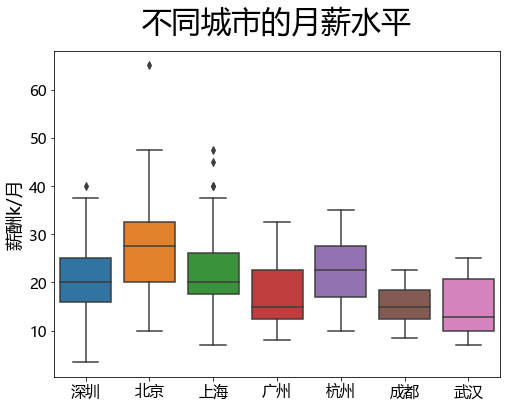

In [154]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = '城市', y = '平均月薪', data = city_salary_data)
plt.title('不同城市的月薪水平', fontsize = 30, pad = 20)
plt.xlabel('')
plt.ylabel('薪酬k/月', fontsize = 18)
plt.tick_params(labelsize = 15)
plt.savefig('S:\\PM_new\不同城市的月薪水平.jpg')

## 城市招聘需求

c:\users\zy\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  city  position_count  explode
0   北京             111      0.0
1   深圳              91      0.0
2   上海              90      0.0
3   广州              41      0.0
4   杭州              29      0.0
5   成都              14      1.1
6   武汉              12      1.1
7   苏州               5      1.1
8   南京               2      1.1


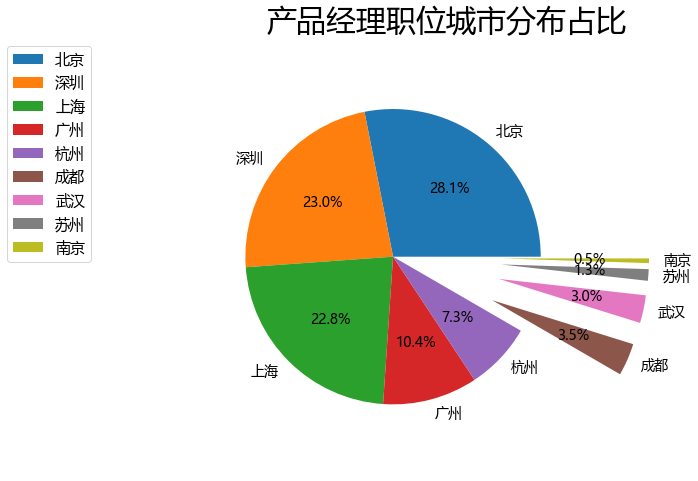

In [157]:
city_positions = data['城市'].value_counts().head(9).reset_index().rename(columns={'index':'city','城市':'position_count'}) 
city_positions['explode'] = city_positions['position_count'].apply(lambda x: 0 if x > 15 else 1.1)
print(city_positions)

plt.figure(figsize=(8, 8))
plt.pie(city_positions['position_count'].tolist(), labels = city_positions['city'].tolist(), autopct='%1.1f%%', 
        explode = city_positions['explode'].tolist(), radius = 1.5, textprops={'fontsize':14, 'color':'black'})
plt.axis('equal') 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(-0.5, 1))
plt.title('产品经理职位城市分布占比', fontsize = 30)
plt.savefig('S:\\PM_new\产品经理职位城市分布占比.jpg')
plt.show()

## 职位要求

In [33]:
text = ''

for line in data['职位描述']:
    text += line

# 使用jieba模块将字符串分割为单词列表

cut_text = ' '.join(jieba.cut(text))


<>:13: DeprecationWarning: invalid escape sequence \z
<>:13: DeprecationWarning: invalid escape sequence \z
<ipython-input-147-61b5be82730b>:13: DeprecationWarning: invalid escape sequence \z
  font_path= 'C:\\Users\zy\Desktop\font\msyh.ttc', stopwords = stopwords).generate(cut_text)


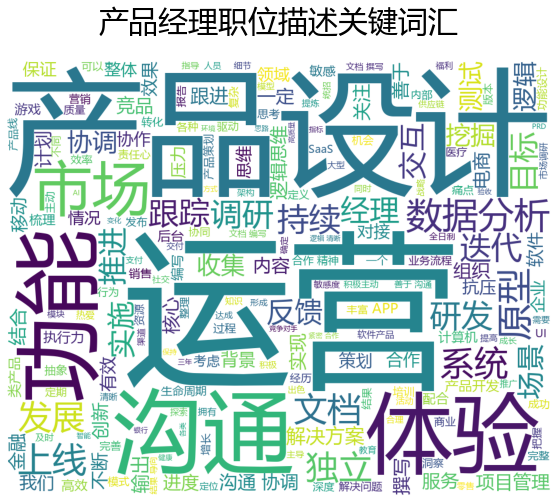

In [147]:
stopwords=('数据','职位描述','工作','工作内容','职责','工作职责','任职要求','职位','描述','产品','经验','熟练',
              '进行','相关','以上学历','使用','工具','本科','提供','负责','业务','熟悉','分析','优先','能力','策略',
              '任职','熟悉','开发','项目','公司','需求','支持','岗位职责','行业','问题','研究','具有','搭建','能够',
              '完成','技术','监控','客户','基于','方法','设计','了解','良好','部门','日常','通过','团队','互联网','根据',
            '建立','以及','具备','发现','应用','业务部门','制定','掌握','要求','平台','基础','以上','推动','体系','管理',
               '较强','学习','管理','资格','建议','专业','落地','协助','执行','价值','方案','提出','解决','快速','优秀','参与',
              '方向','改进','建设','评估','信息','提取','提升','深入','常用','包括','岗位','规划','理解','确保','用户','精通',
           '或者','一种','至少','一门','优化','流程')

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 800, 
                      font_path= 'C:\\Users\zy\Desktop\font\msyh.ttc', stopwords = stopwords).generate(cut_text)
#print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.title('产品经理职位描述关键词汇', fontsize = 30, pad = 30)
plt.savefig('S:\\PM_new\产品经理职位描述关键词汇.jpg')
plt.show()

<>:10: DeprecationWarning: invalid escape sequence \z
<>:10: DeprecationWarning: invalid escape sequence \z
<ipython-input-153-c9f2c25d5a06>:10: DeprecationWarning: invalid escape sequence \z
  font_path = 'C:\\Users\zy\Desktop\font\msyh.ttc', stopwords = stopwords).generate(skills)


[('Axure', 0.619824060043087),
 ('App', 0.5200822572775328),
 ('Prd', 0.44883811244499405),
 ('Visio', 0.41321604002872464),
 ('Saas', 0.3205986517464243),
 ('Ui', 0.27785216484690106),
 ('Product', 0.22798126346412395),
 ('Office', 0.19948360553110844),
 ('Ppt', 0.19948360553110844),
 ('Ai', 0.18523477656460072),
 ('Crm', 0.1638615331148391),
 ('Erp', 0.1567371186315852),
 ('Mindmanager', 0.1567371186315852),
 ('Amp', 0.14248828966507748),
 ('Xmind', 0.14248828966507748),
 ('Web', 0.1068662172488081),
 ('Tob', 0.1068662172488081),
 ('Pc', 0.1068662172488081),
 ('Design', 0.09974180276555422),
 ('Excel', 0.09261738828230036)]

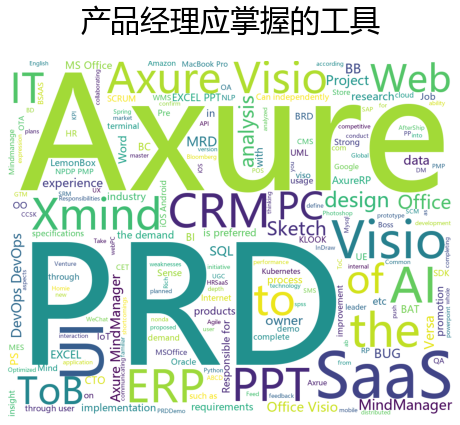

In [153]:
remove_chinese = re.compile(r'[\u4e00-\u9fa5,\u0030-\u0039]') # [\u4e00-\u9fa5]是匹配所有中文的正则，[\u0030-\u0039]是匹配所有数字的正则
all_english = ''.join(remove_chinese.split(text))
en_jd = jieba.cut(all_english, cut_all = False)
skills = " ".join(en_jd)
# 提取关键词, str.title()把每个单词的第一个字母转化为大写，其余小写 
keywords = jieba.analyse.extract_tags(all_english.title(), topK = 20, withWeight = True, allowPOS = ()) # 提取关键字的原理是使用TF-IDF算法

stopwords = ('Product', 'Shopee', '.-', '..', 'Ceo', 'amp', 'APP', 'and')
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 800, 
                      font_path = 'C:\\Users\zy\Desktop\font\msyh.ttc', stopwords = stopwords).generate(skills)
plt.axis('off')
plt.imshow(wordcloud)
plt.title('产品经理应掌握的工具', fontsize = 30, pad = 30)
plt.savefig('S:\\PM_new\产品经理应掌握的工具.jpg')
keywords

In [165]:
data.to_csv('spyder_pm_from_lagou.csv', index=False, encoding = 'utf-8-sig') # 导出数据处理后的最终数据